**Theory**
1.   A Homography transforms a square to arbitrary quad.
2.   Images of two planes are related by a Homography
3.   We need 4 corresponding points to estimate Homography



In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

**Step - 1 : Read Template and Scanned Image**

In [2]:
# Read reference image
ref = "form.jpg"
print("Reading reference image:", ref)
img1 = cv2.imread(ref, cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
image = "scanned-form.jpg"
print("Reading image to align:", image)
img2 = cv2.imread(image, cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

Reading reference image: form.jpg
Reading image to align: scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

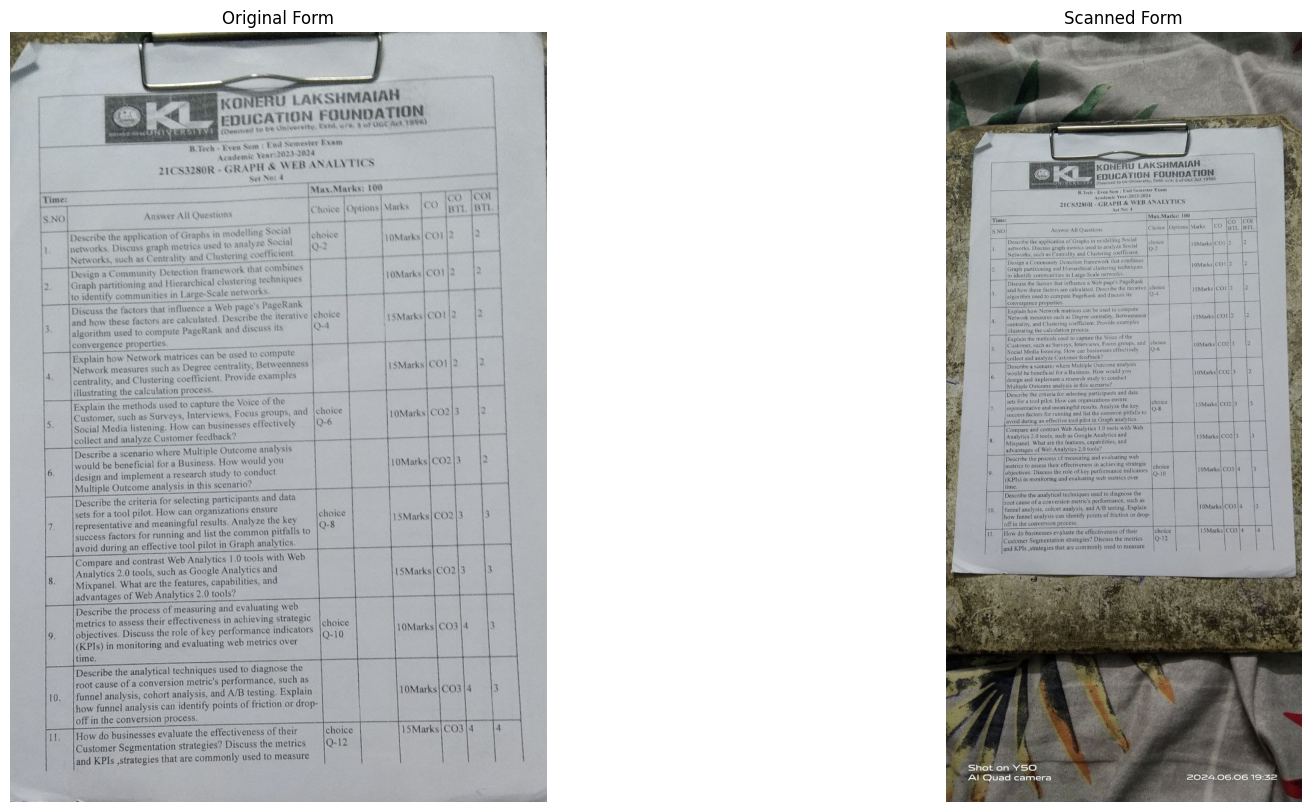

In [3]:
# Display Images

plt.figure(figsize=[20, 10]);
plt.subplot(121);
plt.axis('off');
plt.imshow(img1);
plt.title("Original Form")

plt.subplot(122);
plt.axis('off');
plt.imshow(img2);
plt.title("Scanned Form")

**Step - 2 : Find keypoints in both Images**

Think of keypoints as corner points that are stable under image transformations

1.   ORB (Oriented FAST and Rotated BRIEF) feature detector with the maximum number of features set to 500. ORB is used to find and describe key points in an image.
2.   Keypoints are distinctive points in the image, and descriptors are vectors that describe the region around each keypoint.
3.  The keypoints are drawn in red (color=(255, 0, 0)).
4.  The `flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` option means the keypoints are drawn with additional details, such as the size and orientation of each keypoint.



In [4]:
# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# Display
img1_display = cv2.drawKeypoints(img1, keypoints1, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img2_display = cv2.drawKeypoints(img2, keypoints2, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

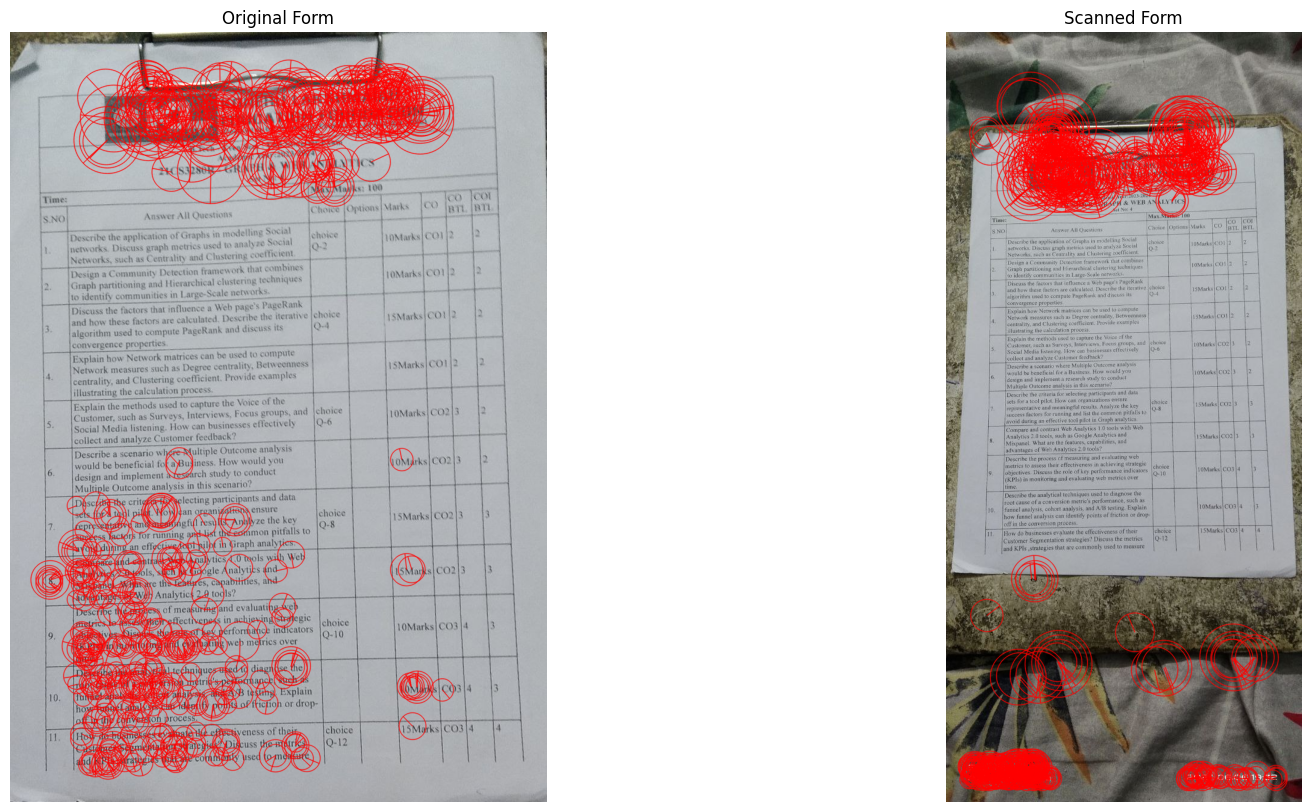

In [5]:
plt.figure(figsize=[20,10])

plt.subplot(121);
plt.axis('off');
plt.imshow(img1_display);
plt.title("Original Form");

plt.subplot(122);
plt.axis('off');
plt.imshow(img2_display);
plt.title("Scanned Form");

**Step - 3 : Match keypoints in both the images**

1.   `matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)` : This line creates a matcher that uses the brute-force Hamming distance method to match the descriptors of the keypoints. The Hamming distance is often used for binary descriptors like those produced by ORB.
2.   `matches.sort(key=lambda x: x.distance, reverse=False)` : This line sorts the list of matches based on their distance attribute in ascending order. The distance represents how similar the descriptors are; smaller distances indicate better matches.
3.  `numGoodMatches = int(len(matches) * 0.1)` : These lines select the top 10% of the best matches.



In [6]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))  # finds the best matches between the descriptors of keypoints in the first image & second image.

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Original Form')

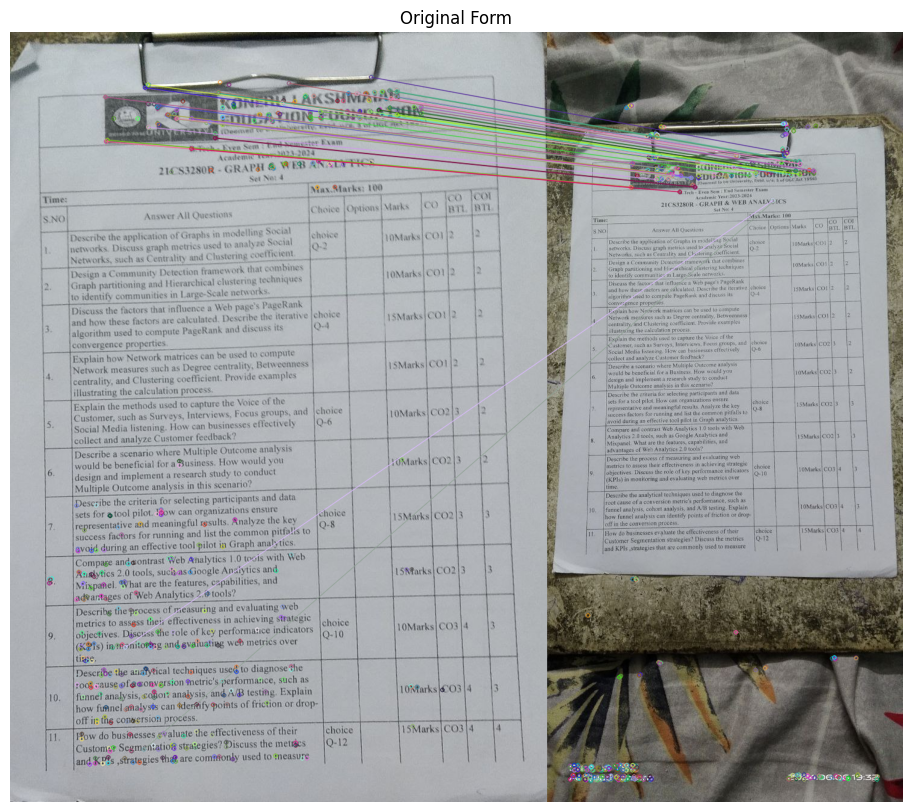

In [7]:
# Draw top matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(img_matches);
plt.axis("off");
plt.title("Original Form")

**Step - 4 : Find Homography**

1.   `match.queryIdx`: It refers to the index of the keypoint in the first image (keypoints1).
2.   `match.trainIdx` : It refers to the index of the keypoint in the second image (keypoints2).The coordinates of the keypoints are stored in points1 and points2 respectively.
3.  `h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)`
*   This line computes the homography matrix h using the RANSAC (Random Sample Consensus) algorithm.
*   A homography is a transformation that maps points from one image to the corresponding points in another image.
*   `cv2.RANSAC`: The method used to estimate the homography matrix robustly, minimizing the influence of outliers.
*   `mask` output is a binary mask that indicates which points were considered inliers during the RANSAC process (1 if the point is an inlier, 0 if it's an outlier).






In [8]:
# Extract location of good matches
#create an array  to hold the coordinates of the matched keypoints from the two images.
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

**Step - 5 : Wrap Image**

Text(0.5, 1.0, 'Scanned Form')

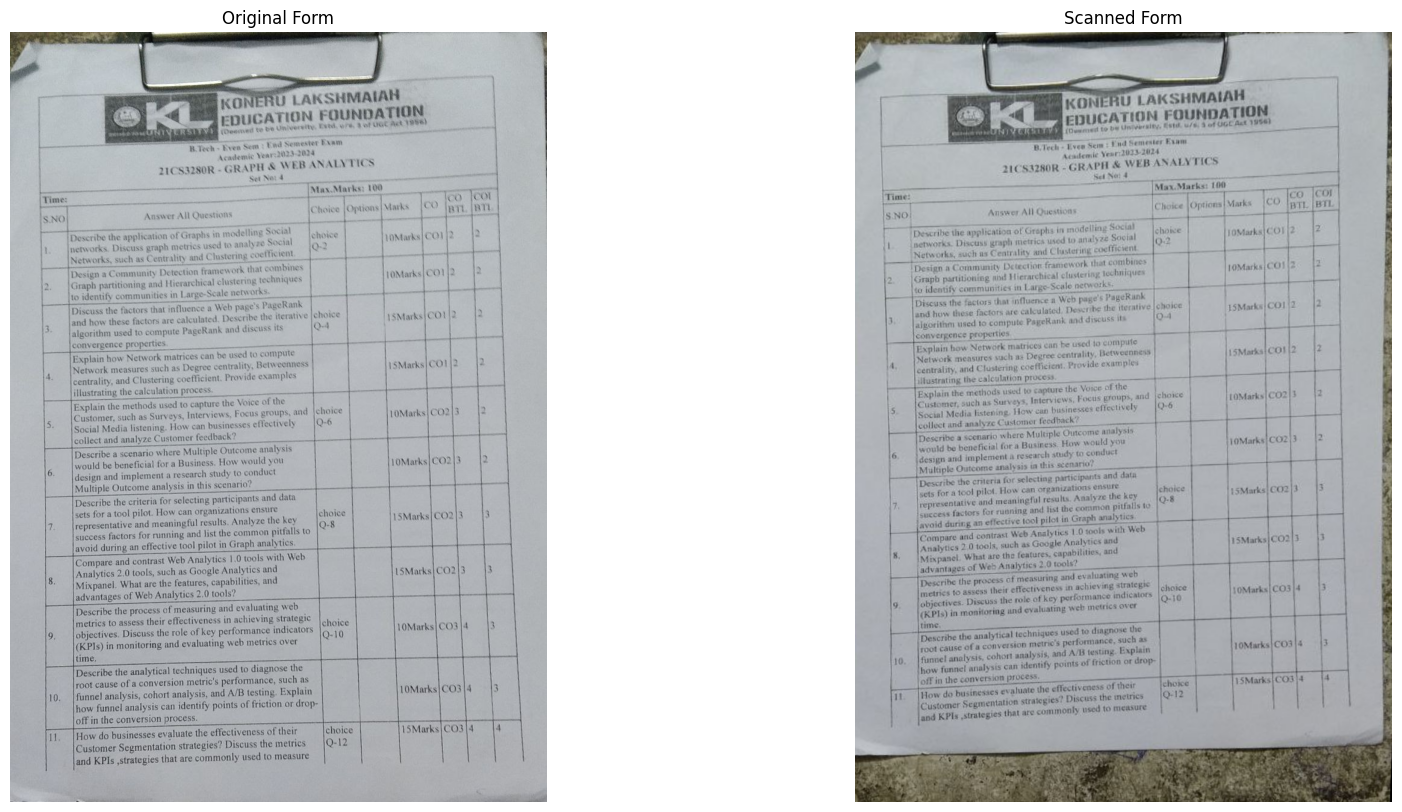

In [9]:
# Use homography to warp image
height, width, channels = img1.shape
img2_reg = cv2.warpPerspective(img2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])

plt.subplot(121);
plt.imshow(img1);
plt.axis("off");
plt.title("Original Form")

plt.subplot(122);
plt.imshow(img2_reg);
plt.axis("off");
plt.title("Scanned Form")